In [950]:
import librosa
import numpy as np
import os
import pandas as pd
import soundfile
import sys
import joblib
import pandas as pd
import numpy as np
import xgboost as xgb
import pickle
import matplotlib
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.svm import SVC, LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import confusion_matrix, f1_score, fbeta_score,accuracy_score, precision_score, recall_score
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.feature_selection import SelectFromModel
from sklearn.utils.class_weight import compute_class_weight
import itertools
from IPython.display import display
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks 

%matplotlib inline

We define a function that takes a set of features per time frame and stack the mean so that the data becomes 1-Dimension.

In [32]:
def feature_to_1d(features):
    result = np.array([])
    mfcc = np.mean(features.T, axis=0)
    result = np.hstack((result, mfcc))
    return result

We import the binary files containing the original features (MFCCs, and Mel-Spectrogram) in 2D form, as well as the labels corresponding to each feature set.

In [804]:
#mel

f = open('IEMOCAP_Data/Data_10_sec/X_train_mel', 'rb')
X_train_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/X_test_mel', 'rb')
X_test_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_train_mel', 'rb')
y_train_mel = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_test_mel', 'rb')
y_test_mel = joblib.load(f)
f.close()

#mfcc

f = open('IEMOCAP_Data/Data_10_sec/X_train_mfcc', 'rb')
X_train_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/X_test_mfcc', 'rb')
X_test_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_train_mfcc', 'rb')
y_train_mfcc = joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_10_sec/y_test_mfcc', 'rb')
y_test_mfcc = joblib.load(f)
f.close()

## Find the indices of clipped audio (test)

In [820]:
X_test_mfcc.shape

(900, 40, 313)

In [858]:
clipped_indices = []

for i in range(900):
    for j in range(40):
        for k in range(313):
            if(k == 312 and X_test_mel[i][j][k] != 0):
                clipped_indices.append(i)

In [859]:
len(clipped_indices)

1600

In [862]:
x_clipped =np.array(clipped_indices)
x_clipped =np.unique(x_clipped)

In [943]:
x_clipped

array([  5,  32,  37,  48,  69,  77,  80,  86, 107, 112, 116, 141, 145,
       154, 168, 172, 204, 210, 231, 236, 330, 351, 372, 417, 419, 464,
       482, 505, 587, 636, 693, 720, 733, 743, 756, 800, 811, 842, 852,
       897])

In [944]:
x_unclipped = []
for i in range(len(X_test_mel)):
    if i not in x_clipped:
        x_unclipped.append(i)
x_unclipped = np.array(x_unclipped)
#x_unclipped

In [946]:
len(x_unclipped)

860

## Examine clipped audio in train set

In [900]:
clipped_indices_train = []

for i in range(900):
    for j in range(40):
        for k in range(313):
            if(k == 312 and X_train_mel[i][j][k] != 0):
                clipped_indices_train.append(i)

In [901]:
x_clipped_t =np.array(clipped_indices_train)
x_clipped_t =np.unique(x_clipped_t)

In [906]:
len(x_clipped_t)

32

In [912]:
train_labels = []
for i in range(len(y_onehot_train_mfcc.argmax(axis=1))):
    if i in x_clipped_t:
        train_labels.append(y_onehot_train_mfcc.argmax(axis=1)[i])
test_labels = []
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if i in x_clipped:
        test_labels.append(y_onehot_test_mfcc.argmax(axis=1)[i])

In [915]:
len(test_labels)

40

In [917]:
from collections import Counter
train = Counter(train_labels)
test = Counter(test_labels)
print("Train: \n{} \n\nTest: \n{}".format(train, test))

Train: 
Counter({2: 12, 5: 9, 4: 6, 1: 3, 0: 2}) 

Test: 
Counter({2: 10, 1: 9, 0: 8, 4: 7, 5: 6})


In [920]:
print("Train count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(train_labels.count(0),train_labels.count(1),train_labels.count(2),train_labels.count(3),train_labels.count(4),train_labels.count(5)))

Train count:
Anger: 2
Happy: 3
Sad: 12
Fear: 0
Surprise: 6
Neutral: 9



In [921]:
print("Test count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(test_labels.count(0),test_labels.count(1),test_labels.count(2),test_labels.count(3),test_labels.count(4),test_labels.count(5)))

Test count:
Anger: 8
Happy: 9
Sad: 10
Fear: 0
Surprise: 7
Neutral: 6



In [922]:
dic_true_val = {}
dic_true_val['ang'] = test_labels.count(0)
dic_true_val['hap'] = test_labels.count(1)
dic_true_val['sad'] = test_labels.count(2)
dic_true_val['fea'] = test_labels.count(3)
dic_true_val['sur'] = test_labels.count(4)
dic_true_val['neu'] = test_labels.count(5)

## Unclipped audio

In [1047]:
unclipped_indices_train = []

for i in range(900):
    for j in range(40):
        for k in range(313):
            if(k == 312 and X_train_mel[i][j][k] != 0):
                unclipped_indices_train.append(i)

In [1048]:
x_unclipped_t =np.array(unclipped_indices_train)
x_unclipped_t =np.unique(x_unclipped_t)

len(x_unclipped_t)

32

In [1049]:
train_labels = []
for i in range(len(y_onehot_train_mfcc.argmax(axis=1))):
    if i in x_unclipped_t:
        train_labels.append(y_onehot_train_mfcc.argmax(axis=1)[i])
test_labels = []
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if i in x_unclipped:
        test_labels.append(y_onehot_test_mfcc.argmax(axis=1)[i])

len(test_labels)


860

In [1050]:
train = Counter(train_labels)
test = Counter(test_labels)
print("Train: \n{} \n\nTest: \n{}".format(train, test))

Train: 
Counter({2: 12, 5: 9, 4: 6, 1: 3, 0: 2}) 

Test: 
Counter({3: 158, 4: 158, 5: 144, 1: 144, 2: 134, 0: 122})


In [1052]:
print("Test count:\nAnger: {}\nHappy: {}\nSad: {}\nFear: {}\nSurprise: {}\nNeutral: {}\n".format(test_labels.count(0),test_labels.count(1),test_labels.count(2),test_labels.count(3),test_labels.count(4),test_labels.count(5)))

Test count:
Anger: 122
Happy: 144
Sad: 134
Fear: 158
Surprise: 158
Neutral: 144



In [1053]:
dic_true_val_unclipped = {}
dic_true_val_unclipped['ang'] = test_labels.count(0)
dic_true_val_unclipped['hap'] = test_labels.count(1)
dic_true_val_unclipped['sad'] = test_labels.count(2)
dic_true_val_unclipped['fea'] = test_labels.count(3)
dic_true_val_unclipped['sur'] = test_labels.count(4)
dic_true_val_unclipped['neu'] = test_labels.count(5)

### Converting to 1D Data

We convert the 2D features to 1D data.

In [662]:
f = open('IEMOCAP_Data/Data_10_sec/X_train_mfcc', 'rb')
X_train_mel_2d_10= joblib.load(f)
f.close()
f = open('IEMOCAP_Data/Data_30_sec/X_train_mfcc', 'rb')
X_train_mel_2d_30 = joblib.load(f)
f.close()

In [672]:
mean_30 = np.mean(X_train_mel_2d_30[0]) 

In [673]:
mean_10 = np.mean(X_train_mel_2d_10[0])

In [674]:
print(mean_30)
print(mean_10)

10.435373
11.396431


In [297]:
X_train_mel_1d = []
X_test_mel_1d = []
X_train_mfcc_1d = []
X_test_mfcc_1d = []

In [298]:
for i in range(len(X_train_mel)):
    X_train_mel_1d.append(feature_to_1d(X_train_mel[i]))
for i in range(len(X_test_mel)):
    X_test_mel_1d.append(feature_to_1d(X_test_mel[i]))
for i in range(len(X_train_mfcc)):
    X_train_mfcc_1d.append(feature_to_1d(X_train_mfcc[i]))
for i in range(len(X_test_mfcc)):
    X_test_mfcc_1d.append(feature_to_1d(X_test_mfcc[i]))

In [299]:
X_train_mel = np.array(X_train_mel_1d)
X_test_mel = np.array(X_test_mel_1d)
X_train_mfcc = np.array(X_train_mfcc_1d)
X_test_mfcc = np.array(X_test_mfcc_1d)

In [300]:
X_train_mel.shape

(2100, 128)

In [301]:
X_train_mfcc.shape

(2100, 40)

Split data into train and test set per feature.

### Transform the y data 

We transform the y data containing the labels into onehot-encoded form so that the models can classify the categorical accuracy and loss.

In [44]:
y_onehot_train_mel = y_train_mel
y_onehot_test_mel = y_test_mel

y_onehot_train_mfcc = y_train_mfcc
y_onehot_test_mfcc = y_test_mfcc

In [45]:
y_onehot_train_mel = pd.get_dummies(y_onehot_train_mel)
y_onehot_test_mel = pd.get_dummies(y_onehot_test_mel)

y_onehot_train_mfcc = pd.get_dummies(y_onehot_train_mfcc)
y_onehot_test_mfcc = pd.get_dummies(y_onehot_test_mfcc)

In [46]:
y_onehot_train_mel = np.asarray(y_onehot_train_mel).astype('int8')
y_onehot_test_mel  = np.asarray(y_onehot_test_mel).astype('int8')

y_onehot_train_mfcc = np.asarray(y_onehot_train_mfcc).astype('int8')
y_onehot_test_mfcc  = np.asarray(y_onehot_test_mfcc).astype('int8')

Import libraries needed for defining the models.

In [396]:
import segmentation_models as sm
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LeakyReLU
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, Lambda, GlobalMaxPooling1D, Concatenate, BatchNormalization, LSTM, Reshape, Conv2D, MaxPooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.regularizers import l2

In [48]:
X_train_mfcc.shape

(2100, 40)

In [623]:
X_train_mel[1]

array([1.09590675e+06, 1.51087738e+06, 2.91274950e+06, 1.97672020e+07,
       1.43971120e+08, 1.14526480e+08, 2.19677060e+07, 7.09604640e+07,
       1.96999568e+08, 5.88081088e+08, 5.09481312e+08, 9.96183744e+08,
       2.28888224e+08, 3.48847600e+07, 1.44513888e+08, 2.44494144e+08,
       1.63201424e+08, 1.16570752e+09, 9.65148032e+08, 1.92716480e+08,
       1.23404640e+08, 7.49460240e+07, 1.75392624e+08, 3.03373792e+08,
       1.99665008e+08, 2.10018656e+08, 4.06420224e+08, 8.88740160e+08,
       7.45806899e+09, 2.76280934e+09, 2.97069056e+08, 1.61298416e+08,
       1.54877840e+08, 7.71990784e+08, 2.38734080e+09, 3.05790080e+08,
       3.42876480e+07, 2.53264960e+07, 1.82338960e+07, 1.12078208e+08,
       2.84509248e+08, 5.22837320e+07, 5.03912720e+07, 3.96290440e+07,
       1.16155544e+08, 2.12306464e+08, 2.03539504e+08, 2.53003536e+08,
       1.61513360e+08, 2.08928560e+08, 7.20520832e+08, 1.16199475e+09,
       5.04297696e+08, 8.71042560e+07, 2.69099232e+08, 8.02708032e+08,
      

Expand the dimensions for the training and testing data so that it can be used for the neural networks.

In [302]:
X_traincnn_mfcc = np.expand_dims(X_train_mfcc, axis = 2)
X_testcnn_mfcc = np.expand_dims(X_test_mfcc, axis = 2)
X_traincnn_mel = np.expand_dims(X_train_mel, axis = 2)
X_testcnn_mel = np.expand_dims(X_test_mel, axis = 2)

#### We define some functions for training and testing

In [50]:
import tensorflow as tf
import tensorflow.keras.backend as K

def f1_loss(y_true, y_pred):

    tp = K.sum(K.cast(y_true*y_pred, 'float'), axis=0)
    tn = K.sum(K.cast((1-y_true)*(1-y_pred), 'float'), axis=0)
    fp = K.sum(K.cast((1-y_true)*y_pred, 'float'), axis=0)
    fn = K.sum(K.cast(y_true*(1-y_pred), 'float'), axis=0)

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    f1 = 2*p*r / (p+r+K.epsilon())
    f1 = tf.where(tf.math.is_nan(f1), tf.zeros_like(f1), f1)
    return 1 - K.mean(f1)

In [793]:
def print_index(y_true, y_pred):
    #['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
    correct_instances_index = [] #indices of correct predictions
    for i in range(len(y_pred)):
        if(y_true[i] == y_pred[i]):
            correct_instances_index.append(i)
            
    return correct_instances_index
def print_labels(y_true, y_pred):
    #['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
    correct_instances_label = [] #labels of correct predictions
    for i in range(len(y_pred)):
        if(y_true[i] == y_pred[i]):
            correct_instances_label.append(y_pred[i])
            
    return correct_instances_label

In [888]:
def count_label(x):
    ang = 0
    hap = 0
    sad = 0
    fea = 0
    sur = 0
    neu = 0
    
    dic = {}
    #my_dict['name']='Nick'
    for i in range(len(x)):
        if(x[i]==0):
            ang += 1
        elif(x[i]==1):
            hap += 1
        elif(x[i]==2):
            sad += 1
        elif(x[i]==3):
            fea += 1
        elif(x[i]==4):
            sur += 1
        elif(x[i]==5):
            neu += 1
    dic['ang'] = ang
    dic['hap'] = hap
    dic['sad'] = sad
    dic['fea'] = fea
    dic['sur'] = sur
    dic['neu'] = neu
    
    return dic

In [51]:
checkpoint_path = 'IEMOCAP_Data/Weights/best_weights.hdf5'

#-> Save the best weights
mcp_save = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True,
                           monitor='val_categorical_accuracy',
                           mode='max')
#-> Reduce learning rate after 100 epoches without improvement.
rlrop = callbacks.ReduceLROnPlateau(monitor='val_categorical_accuracy', 
                                    factor=0.1, patience=100)

In [882]:
emotion_dict = {'ang': 0,
                'hap': 1,
                'sad': 2,
                'fea': 3,
                'sur': 4,
                'neu': 5}

emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    # plt.figure(figsize=(8,8))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    print(num_classes)
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

def display_results(y_test, pred_probs, cm=True):
    pred = np.argmax(pred_probs, axis=-1)
    one_hot_true = one_hot_encoder(y_test, len(pred), len(emotion_dict))
    print('Test Set Accuracy =  {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('Test Set F-score =  {0:.3f}'.format(fbeta_score(y_test, pred, beta= 1.0,average='macro')))
    print('Test Set Precision =  {0:.3f}'.format(precision_score(y_test, pred, average='macro')))
    print('Test Set Recall =  {0:.3f}'.format(recall_score(y_test, pred, average='macro')))
    if cm:
        plot_confusion_matrix(confusion_matrix(y_test, pred), classes=emo_keys)

### TDNN

We define the Time Delay Neural Netowrk Model. The model is based on a TDNN model used for flood prediction presented on ESoWC 2019 (MATHIW - Machine Learning Techniques for High Impact Weather) by Kugler & Lehner (https://github.com/MATEHIW-project).

In [713]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.layers import Dropout
from tensorflow.keras.constraints import MinMaxNorm, NonNeg


def add_time(vector, time, name=None):
    """Converts numpy arrays to xarrays with a time coordinate.

    Parameters
    ----------
    vector : np.array
        1-dimensional array of predictions
    time : xr.DataArray
        the return value of `Xda.time`

    Returns
    -------
    xr.DataArray
    """
    return xr.DataArray(vector, dims=('time'), coords={'time': time}, name=name)


class DenseNN(object):
    def __init__(self, **kwargs):
        self.xscaler = StandardScaler()
        self.yscaler = StandardScaler()
        
        
        model = Sequential()
        self.cfg = kwargs
        
        hidden_nodes = self.cfg.get('hidden_nodes')
        input_shape = self.cfg.get('input_shape')
        self.epoch = self.cfg.get('epochs')
        self.batch_size = self.cfg.get('batch_size')
        
        

        model.add(layers.Input(shape=(input_shape, 1)))
        model.add(Dense(hidden_nodes[0], 
                                activation='relu'))
        model.add(BatchNormalization())
        model.add(Dropout(self.cfg.get('dropout', None)))
        
        for n in hidden_nodes[1:]:
            model.add(Dense(n, activation='relu')) 
            model.add(BatchNormalization())
            model.add(Dropout(self.cfg.get('dropout', None)))
        model.add(Flatten())
        model.add(Dense(6, activation='softmax'))
        opt = tf.keras.optimizers.Adam(lr=0.0005) 
        
        #opt2 = tf.keras.optimizers.SGD(lr=0.0005)
        model.compile(loss='categorical_crossentropy',
              optimizer= opt,
              metrics=['categorical_accuracy', f1_loss])
        self.model = model

        self.callbacks = [tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                            min_delta=1e-2, patience=100, verbose=0, mode='auto',
                            baseline=None, restore_best_weights=True),]
    
    def score_func(self, X, y):
        """Calculate the RMS error
        
        Parameters
        ----------
        xr.DataArrays
        """
        ypred = self.predict(X)
        err_pred = ypred - y
        
        # NaNs do not contribute to error
        err_pred = err_pred.where(~np.isnan(err_pred), 0.)  
        return float(np.sqrt(xr.dot(err_pred, err_pred)))
        
    def predict(self, Xda, name=None):
        """Input and Output: xr.DataArray
        
        Parameters
        ----------
        Xda : xr.DataArray
            with coordinates (time,)
        """
        #X = self.xscaler.transform(Xda.values)
        #y = self.model.predict(X).squeeze()
        #y = self.yscaler.inverse_transform(y)
        
        #y = add_time(y, Xda.time, name=name)
        return self.model.predict(Xda)

    def evaluate(self, X, y):
        return self.model.evaluate(X, y)
    
    def fit(self, X_train, y_train, X_valid, y_valid, **kwargs):
        """
        Input: xr.DataArray
        Output: None
        """
        
        #print(X_train.shape)
        #X_train = self.xscaler.fit_transform(X_train)
        #y_train = self.yscaler.fit_transform(
                        #y_train.reshape(-1, 6))
        
        #X_valid = self.xscaler.transform(X_valid)
        #y_valid = self.yscaler.transform(y_valid.reshape(-1, 6))
        
        return self.model.fit(X_train, y_train,
                              validation_data=(X_valid, y_valid), 
                              epochs=self.epoch,
                              batch_size=self.batch_size, **kwargs)
    def predict_classes(X):
        return model.predict_classes(X)
    
    def summary(self):
        return self.model.summary()

#### MFCC

We use MFCC as input features.

In [763]:
print(X_train_mfcc_np.shape)
print(X_test_mfcc_np.shape)
print(y_onehot_train_mfcc.shape)
print(y_onehot_test_mfcc.shape)

(2100, 40)
(900, 40)
(2100, 6)
(900, 6)


In [764]:
X_train_mfcc_np = np.array(X_train_mfcc)
X_test_mfcc_np = np.array(X_test_mfcc)
y_train_mfcc_np = np.array(y_train_mfcc)
y_test_mfcc_np = np.array(y_test_mfcc)

In [765]:
X_test_mfcc_np.shape

(900, 40)

In [771]:
config = dict(hidden_nodes=(64, 32),  
                input_shape=40,
                dropout=0.25,
                epochs=35,
                batch_size=50)

m_2 = DenseNN(**config)

hist_2 = m_2.fit(X_traincnn_mfcc, y_onehot_train_mfcc, X_testcnn_mfcc, y_onehot_test_mfcc)

Epoch 1/35
42/42 [==============================] - 1s 16ms/step - loss: 2.3144 - categorical_accuracy: 0.1906 - f1_loss: 0.8281 - val_loss: 1.8218 - val_categorical_accuracy: 0.1789 - val_f1_loss: 0.8268
Epoch 2/35
42/42 [==============================] - 0s 10ms/step - loss: 1.8743 - categorical_accuracy: 0.2831 - f1_loss: 0.7657 - val_loss: 1.6515 - val_categorical_accuracy: 0.3078 - val_f1_loss: 0.8008
Epoch 3/35
42/42 [==============================] - 0s 11ms/step - loss: 1.6397 - categorical_accuracy: 0.3695 - f1_loss: 0.7224 - val_loss: 1.6103 - val_categorical_accuracy: 0.3300 - val_f1_loss: 0.7845
Epoch 4/35
42/42 [==============================] - 0s 11ms/step - loss: 1.5251 - categorical_accuracy: 0.3887 - f1_loss: 0.6980 - val_loss: 1.4913 - val_categorical_accuracy: 0.4144 - val_f1_loss: 0.7572
Epoch 5/35
42/42 [==============================] - 0s 10ms/step - loss: 1.3953 - categorical_accuracy: 0.4595 - f1_loss: 0.6553 - val_loss: 1.4785 - val_categorical_accuracy: 0.39

In [772]:
m_2.summary()

Model: "sequential_110"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_216 (Dense)            (None, 40, 64)            128       
_________________________________________________________________
batch_normalization_132 (Bat (None, 40, 64)            256       
_________________________________________________________________
dropout_282 (Dropout)        (None, 40, 64)            0         
_________________________________________________________________
dense_217 (Dense)            (None, 40, 32)            2080      
_________________________________________________________________
batch_normalization_133 (Bat (None, 40, 32)            128       
_________________________________________________________________
dropout_283 (Dropout)        (None, 40, 32)            0         
_________________________________________________________________
flatten_28 (Flatten)         (None, 1280)           

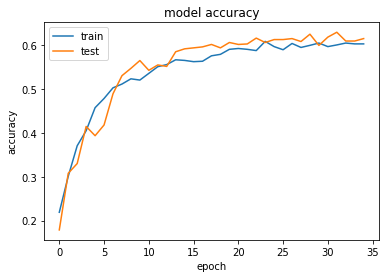

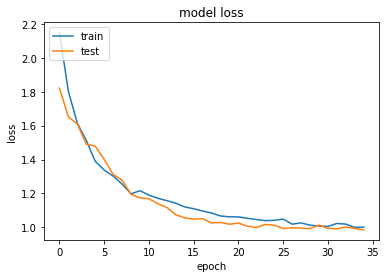

In [773]:
plt.plot(hist_2.history['categorical_accuracy'])
plt.plot(hist_2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_2.history['loss'])
plt.plot(hist_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [1029]:
loss, acc, f1_score = m_2.evaluate(X_testcnn_mfcc, y_onehot_test_mfcc)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 3ms/step - loss: 0.9845 - categorical_accuracy: 0.6144 - f1_loss: 0.5224
Restored model, accuracy: 61.44%


Confusion matrix, without normalization
[[ 87  18   7   0  12   6]
 [ 36  60  14   2  28  13]
 [ 19  13  73   2  20  17]
 [  0   0   0 158   0   0]
 [  4  10  19   0 128   4]
 [ 15  22  37   1  28  47]]


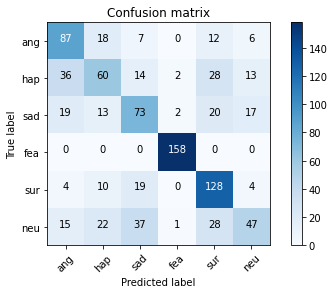

In [1030]:
from sklearn import metrics
y_pred = m_2.predict(X_testcnn_mfcc)
matrix = metrics.confusion_matrix(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [1031]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.54      0.67      0.60       130
         hap       0.49      0.39      0.43       153
         sad       0.49      0.51      0.50       144
         fea       0.97      1.00      0.98       158
         sur       0.59      0.78      0.67       165
         neu       0.54      0.31      0.40       150

    accuracy                           0.61       900
   macro avg       0.60      0.61      0.60       900
weighted avg       0.61      0.61      0.60       900



In [1032]:
# indices and labels of all correctly recognized
correct_indices = print_index(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
correct_labels = print_labels(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))

In [1033]:
len(correct_indices)

553

In [1034]:
# indices of correctly recognized AND clipped
indices_of_clipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i in x_clipped):
                indices_of_clipped_recognized.append(i)

In [1035]:
label_of_clipped_recognized = []
# we get the label of correctly recognized clipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_clipped_recognized):
        label_of_clipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

In [1036]:
dic_val_clipped = count_label(label_of_clipped_recognized)

In [1037]:
dic_val_clipped

{'ang': 8, 'hap': 4, 'sad': 6, 'fea': 0, 'sur': 3, 'neu': 3}

<BarContainer object of 6 artists>

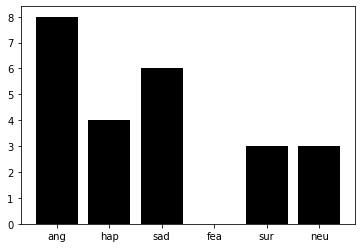

In [1038]:
plt.bar(list(dic_val_clipped.keys()), dic_val_clipped.values(), color='black')

In [1054]:
clipped_ratio = len(indices_of_clipped_recognized) / len(x_clipped)
print("Number of recognized clipped test data: {}\nTotal number of clipped test data: {}\nRatio of recognized clipped test data: {}\n".format(len(indices_of_clipped_recognized),len(x_clipped), clipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_clipped['ang'],dic_val_clipped['hap'],dic_val_clipped['sad'],dic_val_clipped['sur'],dic_val_clipped['neu'],dic_val_clipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val['ang'],dic_true_val['hap'],dic_true_val['sad'],dic_true_val['sur'],dic_true_val['neu'],dic_true_val['fea']))

Number of recognized clipped test data: 24
Total number of clipped test data: 40
Ratio of recognized clipped test data: 0.6

Anger: 8
Happiness: 4
Sadness: 6
Surpise: 3
Neutral: 3
Fear: 0

Anger: 8
Happiness: 9
Sadness: 10
Surpise: 7
Neutral: 6
Fear: 0



In [1041]:
# we get the indices of correctly recognized un-clipped audios
indices_of_unclipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i not in x_clipped):
                indices_of_unclipped_recognized.append(i)

In [941]:
len(indices_of_unclipped_recognized)

529

In [932]:
label_of_unclipped_recognized = []
# we get the label of correctly recognized unclipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_unclipped_recognized):
        label_of_unclipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

In [936]:
dic_val_unclipped = count_label(label_of_unclipped_recognized)

<BarContainer object of 6 artists>

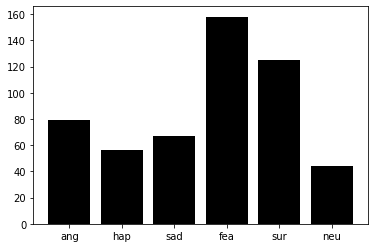

In [937]:
plt.bar(list(dic_val_unclipped.keys()), dic_val_unclipped.values(), color='black')

In [1055]:
unclipped_ratio = len(indices_of_unclipped_recognized) / len(x_unclipped)
print("Number of recognized unclipped test data: {}\nTotal number of unclipped test data: {}\nRatio of recognized unclipped test data: {}\n".format(len(indices_of_unclipped_recognized),len(x_unclipped), unclipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_unclipped['ang'],dic_val_unclipped['hap'],dic_val_unclipped['sad'],dic_val_unclipped['sur'],dic_val_unclipped['neu'],dic_val_unclipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val_unclipped['ang'],dic_true_val_unclipped['hap'],dic_true_val_unclipped['sad'],dic_true_val_unclipped['sur'],dic_true_val_unclipped['neu'],dic_true_val_unclipped['fea']))

Number of recognized unclipped test data: 529
Total number of unclipped test data: 860
Ratio of recognized unclipped test data: 0.6151162790697674

Anger: 57
Happiness: 52
Sadness: 20
Surpise: 147
Neutral: 60
Fear: 158

Anger: 122
Happiness: 144
Sadness: 134
Surpise: 158
Neutral: 144
Fear: 158



#### MEL

We use Mel-Spectrogram as input features.

In [677]:
X_train_mel_np = np.array(X_train_mel)
X_test_mel_np = np.array(X_test_mel)
y_train_mel_np = np.array(y_train_mel)
y_test_mel_np = np.array(y_test_mel)

In [758]:
config = dict(hidden_nodes=(64,32,16),  
                input_shape=128,
                dropout=0.25,
                epochs=30,
                batch_size=50)

m_mel_2 = DenseNN(**config)
hist_mel_2 = m_mel_2.fit(X_traincnn_mel, y_onehot_train_mel, X_testcnn_mel, y_onehot_test_mel)

Epoch 1/30
42/42 [==============================] - 2s 29ms/step - loss: 2.6009 - categorical_accuracy: 0.1682 - f1_loss: 0.8391 - val_loss: 1.7626 - val_categorical_accuracy: 0.2067 - val_f1_loss: 0.8031
Epoch 2/30
42/42 [==============================] - 1s 21ms/step - loss: 1.9184 - categorical_accuracy: 0.3032 - f1_loss: 0.7538 - val_loss: 1.5813 - val_categorical_accuracy: 0.3233 - val_f1_loss: 0.7616
Epoch 3/30
42/42 [==============================] - 1s 21ms/step - loss: 1.7056 - categorical_accuracy: 0.3788 - f1_loss: 0.7054 - val_loss: 1.4997 - val_categorical_accuracy: 0.4322 - val_f1_loss: 0.7401
Epoch 4/30
42/42 [==============================] - 1s 21ms/step - loss: 1.5950 - categorical_accuracy: 0.4162 - f1_loss: 0.6724 - val_loss: 1.4242 - val_categorical_accuracy: 0.4411 - val_f1_loss: 0.7145
Epoch 5/30
42/42 [==============================] - 1s 23ms/step - loss: 1.4437 - categorical_accuracy: 0.4584 - f1_loss: 0.6460 - val_loss: 1.3810 - val_categorical_accuracy: 0.47

In [759]:
m_mel_2.summary()

Model: "sequential_108"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_209 (Dense)            (None, 128, 64)           128       
_________________________________________________________________
batch_normalization_127 (Bat (None, 128, 64)           256       
_________________________________________________________________
dropout_277 (Dropout)        (None, 128, 64)           0         
_________________________________________________________________
dense_210 (Dense)            (None, 128, 32)           2080      
_________________________________________________________________
batch_normalization_128 (Bat (None, 128, 32)           128       
_________________________________________________________________
dropout_278 (Dropout)        (None, 128, 32)           0         
_________________________________________________________________
dense_211 (Dense)            (None, 128, 16)        

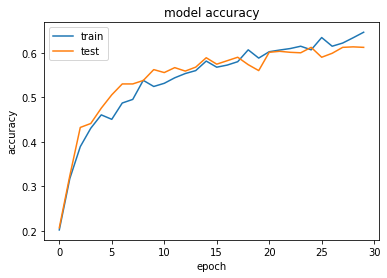

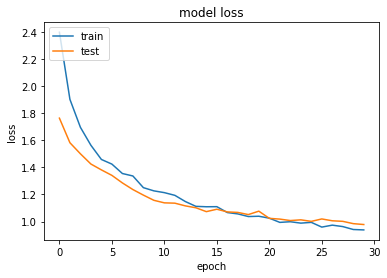

In [760]:
plt.plot(hist_mel_2.history['categorical_accuracy'])
plt.plot(hist_mel_2.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(hist_mel_2.history['loss'])
plt.plot(hist_mel_2.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [962]:
loss, acc, f1_score = m_mel_2.evaluate(X_testcnn_mel, y_onehot_test_mel)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 5ms/step - loss: 0.9780 - categorical_accuracy: 0.6122 - f1_loss: 0.5266
Restored model, accuracy: 61.22%


Confusion matrix, without normalization
[[ 80  21   9   0   6  14]
 [ 22  69  11   1  13  37]
 [ 15  28  35   2  12  52]
 [  0   0   0 158   0   0]
 [  0  20  12   0 122  11]
 [ 11  27  21   0   4  87]]


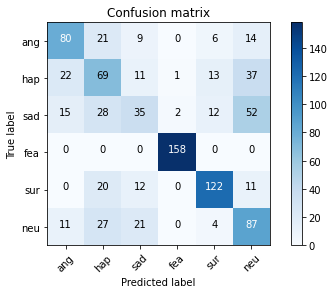

In [1056]:
y_pred = m_mel_2.predict(X_testcnn_mel)
matrix = metrics.confusion_matrix(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [1057]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.62      0.62      0.62       130
         hap       0.42      0.45      0.43       153
         sad       0.40      0.24      0.30       144
         fea       0.98      1.00      0.99       158
         sur       0.78      0.74      0.76       165
         neu       0.43      0.58      0.50       150

    accuracy                           0.61       900
   macro avg       0.61      0.60      0.60       900
weighted avg       0.61      0.61      0.61       900



In [1058]:
# indices and labels of all correctly recognized
correct_indices = print_index(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1))
correct_labels = print_labels(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1))

# indices of correctly recognized AND clipped
indices_of_clipped_recognized = []
for i in range(len(X_testcnn_mel)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i in x_clipped):
                indices_of_clipped_recognized.append(i)

label_of_clipped_recognized = []

# we get the label of correctly recognized clipped audios
for i in range(len(y_onehot_test_mel.argmax(axis=1))):
    if(i in indices_of_clipped_recognized):
        label_of_clipped_recognized.append((y_onehot_test_mel.argmax(axis=1)[i]))

In [1059]:
dic_val_clipped = count_label(label_of_clipped_recognized)

In [1060]:
dic_val_clipped

{'ang': 5, 'hap': 7, 'sad': 3, 'fea': 0, 'sur': 7, 'neu': 5}

<BarContainer object of 6 artists>

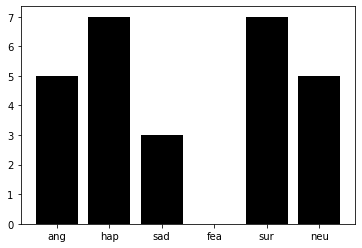

In [1061]:
plt.bar(list(dic_val_clipped.keys()), dic_val_clipped.values(), color='black')

In [1063]:
clipped_ratio = len(indices_of_clipped_recognized) / len(x_clipped)
print("Number of recognized clipped test data: {}\nTotal number of clipped test data: {}\nRatio of recognized clipped test data: {}\n".format(len(indices_of_clipped_recognized),len(x_clipped), clipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_clipped['ang'],dic_val_clipped['hap'],dic_val_clipped['sad'],dic_val_clipped['sur'],dic_val_clipped['neu'],dic_val_clipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val['ang'],dic_true_val['hap'],dic_true_val['sad'],dic_true_val['sur'],dic_true_val['neu'],dic_true_val['fea']))

Number of recognized clipped test data: 27
Total number of clipped test data: 40
Ratio of recognized clipped test data: 0.675

Anger: 5
Happiness: 7
Sadness: 3
Surpise: 7
Neutral: 5
Fear: 0

Anger: 8
Happiness: 9
Sadness: 10
Surpise: 7
Neutral: 6
Fear: 0



In [1064]:
# we get the indices of correctly recognized un-clipped audios
indices_of_unclipped_recognized = []
for i in range(len(X_testcnn_mel)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i not in x_clipped):
                indices_of_unclipped_recognized.append(i)

<BarContainer object of 6 artists>

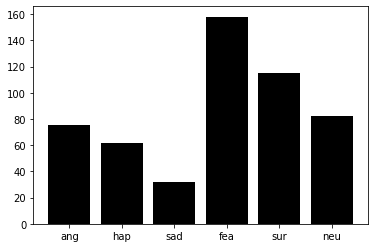

In [1065]:
label_of_unclipped_recognized = []
# we get the label of correctly recognized unclipped audios
for i in range(len(y_onehot_test_mel.argmax(axis=1))):
    if(i in indices_of_unclipped_recognized):
        label_of_unclipped_recognized.append((y_onehot_test_mel.argmax(axis=1)[i]))

dic_val_unclipped = count_label(label_of_unclipped_recognized)

plt.bar(list(dic_val_unclipped.keys()), dic_val_unclipped.values(), color='black')

In [1066]:
unclipped_ratio = len(indices_of_unclipped_recognized) / len(x_unclipped)
print("Number of recognized unclipped test data: {}\nTotal number of unclipped test data: {}\nRatio of recognized unclipped test data: {}\n".format(len(indices_of_unclipped_recognized),len(x_unclipped), unclipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_unclipped['ang'],dic_val_unclipped['hap'],dic_val_unclipped['sad'],dic_val_unclipped['sur'],dic_val_unclipped['neu'],dic_val_unclipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val_unclipped['ang'],dic_true_val_unclipped['hap'],dic_true_val_unclipped['sad'],dic_true_val_unclipped['sur'],dic_true_val_unclipped['neu'],dic_true_val_unclipped['fea']))

Number of recognized unclipped test data: 524
Total number of unclipped test data: 860
Ratio of recognized unclipped test data: 0.6093023255813953

Anger: 75
Happiness: 62
Sadness: 32
Surpise: 115
Neutral: 82
Fear: 158

Anger: 122
Happiness: 144
Sadness: 134
Surpise: 158
Neutral: 144
Fear: 158



## CNN + LSTM

We create a CNN model with LSTM based on a paper on Speech Emotion Recognition by Zhao et al., the reference to the github is: (https://github.com/vandana-rajan/1D-Speech-Emotion-Recognition).

### MFCC

We use MFCC as input features.

In [683]:
model_mfcc_lstm = Sequential()

#LFLB - Local Feature Learning Block

model_mfcc_lstm.add(Conv1D(32, 6,padding='same',input_shape=(40,1)))        #1
model_mfcc_lstm.add(Activation('relu'))
model_mfcc_lstm.add(MaxPooling1D(pool_size=(5)))
model_mfcc_lstm.add(BatchNormalization()) #
model_mfcc_lstm.add(Dropout(0.01))

model_mfcc_lstm.add(Conv1D(64, 6,padding='same',))                           #2
model_mfcc_lstm.add(Activation('relu'))
model_mfcc_lstm.add(MaxPooling1D(pool_size=(5)))
model_mfcc_lstm.add(Dropout(0.01))

model_mfcc_lstm.add(Conv1D(64, 6,padding='same',))                           #3
model_mfcc_lstm.add(Activation('relu'))
model_mfcc_lstm.add(Dropout(0.01))

model_mfcc_lstm.add(Conv1D(128, 6,padding='same',))                           #4 ...
model_mfcc_lstm.add(Activation('relu'))
model_mfcc_lstm.add(Dropout(0.01))

# LSTM
model_mfcc_lstm.add(LSTM(64,return_sequences=True))
model_mfcc_lstm.add(SeqSelfAttention(attention_activation='tanh'))
model_mfcc_lstm.add(LSTM(32,return_sequences=False))

# FC
model_mfcc_lstm.add(Dense(units=6, activation='softmax'))

In [684]:
opt = tf.keras.optimizers.Adam(lr=0.0005) 

In [685]:
model_mfcc_lstm.summary()

Model: "sequential_95"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_161 (Conv1D)          (None, 40, 32)            224       
_________________________________________________________________
activation_201 (Activation)  (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_108 (MaxPoolin (None, 8, 32)             0         
_________________________________________________________________
batch_normalization_102 (Bat (None, 8, 32)             128       
_________________________________________________________________
dropout_240 (Dropout)        (None, 8, 32)             0         
_________________________________________________________________
conv1d_162 (Conv1D)          (None, 8, 64)             12352     
_________________________________________________________________
activation_202 (Activation)  (None, 8, 64)           

In [686]:
model_mfcc_lstm.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['categorical_accuracy', f1_loss])

In [687]:
cnnhistory_lstm_mfcc=model_mfcc_lstm.fit(X_traincnn_mfcc, y_onehot_train_mfcc, batch_size=50, epochs=50, validation_data=(X_testcnn_mfcc, y_onehot_test_mfcc), callbacks=[mcp_save, rlrop])

Epoch 1/50
42/42 [==============================] - 5s 36ms/step - loss: 1.7902 - categorical_accuracy: 0.1747 - f1_loss: 0.8369 - val_loss: 1.7780 - val_categorical_accuracy: 0.1633 - val_f1_loss: 0.8342
Epoch 2/50
42/42 [==============================] - 1s 14ms/step - loss: 1.7553 - categorical_accuracy: 0.2260 - f1_loss: 0.8293 - val_loss: 1.7312 - val_categorical_accuracy: 0.2156 - val_f1_loss: 0.8182
Epoch 3/50
42/42 [==============================] - 1s 14ms/step - loss: 1.6478 - categorical_accuracy: 0.2911 - f1_loss: 0.8004 - val_loss: 1.6183 - val_categorical_accuracy: 0.2722 - val_f1_loss: 0.7966
Epoch 4/50
42/42 [==============================] - 1s 15ms/step - loss: 1.5262 - categorical_accuracy: 0.3693 - f1_loss: 0.7600 - val_loss: 1.4951 - val_categorical_accuracy: 0.3822 - val_f1_loss: 0.7610
Epoch 5/50
42/42 [==============================] - 1s 14ms/step - loss: 1.4423 - categorical_accuracy: 0.3865 - f1_loss: 0.7317 - val_loss: 1.6139 - val_categorical_accuracy: 0.26

In [973]:
loss, acc, f1_score = model_mfcc_lstm.evaluate(X_testcnn_mfcc, y_onehot_test_mfcc)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 4ms/step - loss: 0.8617 - categorical_accuracy: 0.6389 - f1_loss: 0.4612
Restored model, accuracy: 63.89%


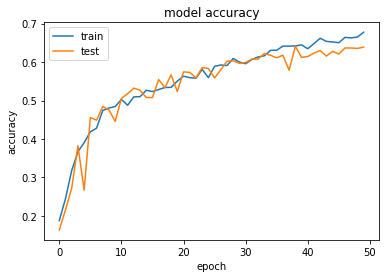

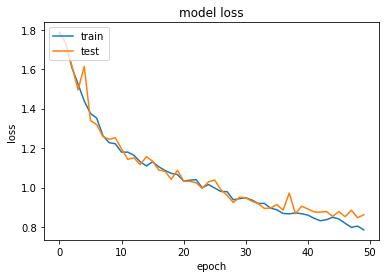

In [974]:
plt.plot(cnnhistory_lstm_mfcc.history['categorical_accuracy'])
plt.plot(cnnhistory_lstm_mfcc.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnnhistory_lstm_mfcc.history['loss'])
plt.plot(cnnhistory_lstm_mfcc.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[ 77  27   3   0   7  16]
 [ 29  56  11   0  21  36]
 [ 15  20  41   0   4  64]
 [  0   0   0 158   0   0]
 [  2   0   0   0 156   7]
 [ 11  16  19   0  17  87]]


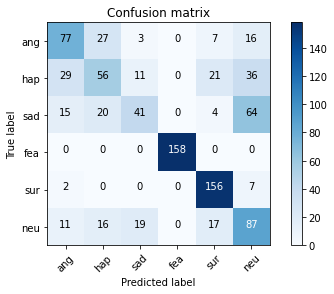

In [1068]:
y_pred = model_mfcc_lstm.predict(X_testcnn_mfcc)
matrix = metrics.confusion_matrix(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [1069]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.57      0.59      0.58       130
         hap       0.47      0.37      0.41       153
         sad       0.55      0.28      0.38       144
         fea       1.00      1.00      1.00       158
         sur       0.76      0.95      0.84       165
         neu       0.41      0.58      0.48       150

    accuracy                           0.64       900
   macro avg       0.63      0.63      0.62       900
weighted avg       0.64      0.64      0.63       900



In [1070]:
# indices and labels of all correctly recognized
correct_indices = print_index(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
correct_labels = print_labels(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))

# indices of correctly recognized AND clipped
indices_of_clipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i in x_clipped):
                indices_of_clipped_recognized.append(i)

label_of_clipped_recognized = []
# we get the label of correctly recognized clipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_clipped_recognized):
        label_of_clipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

dic_val_clipped = count_label(label_of_clipped_recognized)

In [1071]:
dic_val_clipped

{'ang': 8, 'hap': 7, 'sad': 4, 'fea': 0, 'sur': 7, 'neu': 5}

<BarContainer object of 6 artists>

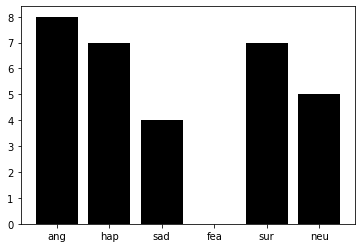

In [1072]:
plt.bar(list(dic_val_clipped.keys()), dic_val_clipped.values(), color='black')

In [1073]:
clipped_ratio = len(indices_of_clipped_recognized) / len(x_clipped)
print("Number of recognized clipped test data: {}\nTotal number of clipped test data: {}\nRatio of recognized clipped test data: {}\n".format(len(indices_of_clipped_recognized),len(x_clipped), clipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_clipped['ang'],dic_val_clipped['hap'],dic_val_clipped['sad'],dic_val_clipped['sur'],dic_val_clipped['neu'],dic_val_clipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val['ang'],dic_true_val['hap'],dic_true_val['sad'],dic_true_val['sur'],dic_true_val['neu'],dic_true_val['fea']))

Number of recognized clipped test data: 31
Total number of clipped test data: 40
Ratio of recognized clipped test data: 0.775

Anger: 8
Happiness: 7
Sadness: 4
Surpise: 7
Neutral: 5
Fear: 0

Anger: 8
Happiness: 9
Sadness: 10
Surpise: 7
Neutral: 6
Fear: 0



In [1074]:
# we get the indices of correctly recognized un-clipped audios
indices_of_unclipped_recognized = []
for i in range(len(X_testcnn_mfcc)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i not in x_clipped):
                indices_of_unclipped_recognized.append(i)

label_of_unclipped_recognized = []
# we get the label of correctly recognized unclipped audios
for i in range(len(y_onehot_test_mfcc.argmax(axis=1))):
    if(i in indices_of_unclipped_recognized):
        label_of_unclipped_recognized.append((y_onehot_test_mfcc.argmax(axis=1)[i]))

dic_val_unclipped = count_label(label_of_unclipped_recognized)

In [1075]:
dic_val_unclipped

{'ang': 69, 'hap': 49, 'sad': 37, 'fea': 158, 'sur': 149, 'neu': 82}

<BarContainer object of 6 artists>

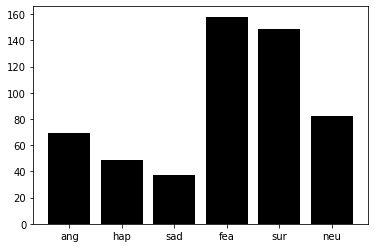

In [1076]:
plt.bar(list(dic_val_unclipped.keys()), dic_val_unclipped.values(), color='black')

In [1077]:
unclipped_ratio = len(indices_of_unclipped_recognized) / len(x_unclipped)
print("Number of recognized unclipped test data: {}\nTotal number of unclipped test data: {}\nRatio of recognized unclipped test data: {}\n".format(len(indices_of_unclipped_recognized),len(x_unclipped), unclipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_unclipped['ang'],dic_val_unclipped['hap'],dic_val_unclipped['sad'],dic_val_unclipped['sur'],dic_val_unclipped['neu'],dic_val_unclipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val_unclipped['ang'],dic_true_val_unclipped['hap'],dic_true_val_unclipped['sad'],dic_true_val_unclipped['sur'],dic_true_val_unclipped['neu'],dic_true_val_unclipped['fea']))

Number of recognized unclipped test data: 544
Total number of unclipped test data: 860
Ratio of recognized unclipped test data: 0.6325581395348837

Anger: 69
Happiness: 49
Sadness: 37
Surpise: 149
Neutral: 82
Fear: 158

Anger: 122
Happiness: 144
Sadness: 134
Surpise: 158
Neutral: 144
Fear: 158



### MEL

We use Mel Spectrogram as input features.

In [706]:
model_mel_lstm = Sequential()

#LFLB - Local Feature Learning Block

model_mel_lstm.add(Conv1D(32, 6,padding='same',input_shape=(128,1)))        #1
model_mel_lstm.add(Activation('relu'))
model_mel_lstm.add(MaxPooling1D(pool_size=(5)))
model_mel_lstm.add(BatchNormalization()) #
model_mel_lstm.add(Dropout(0.25))

model_mel_lstm.add(Conv1D(64, 6,padding='same',))                           #2
model_mel_lstm.add(Activation('relu'))
model_mel_lstm.add(MaxPooling1D(pool_size=(5)))
model_mel_lstm.add(Dropout(0.25))

model_mel_lstm.add(Conv1D(128, 6,padding='same',))                           #3
model_mel_lstm.add(Activation('relu'))
model_mel_lstm.add(Dropout(0.25))

model_mel_lstm.add(Conv1D(256, 6,padding='same',))                           #4 ...
model_mel_lstm.add(Activation('relu'))
model_mel_lstm.add(Dropout(0.25))

# LSTM
model_mel_lstm.add(LSTM(64,return_sequences=True))
model_mel_lstm.add(SeqSelfAttention(attention_activation='tanh'))
model_mel_lstm.add(LSTM(32,return_sequences=False))

# FC
model_mel_lstm.add(Dense(units=6, activation='softmax'))

In [707]:
model_mel_lstm.summary()

Model: "sequential_99"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_175 (Conv1D)          (None, 128, 32)           224       
_________________________________________________________________
activation_216 (Activation)  (None, 128, 32)           0         
_________________________________________________________________
max_pooling1d_114 (MaxPoolin (None, 25, 32)            0         
_________________________________________________________________
batch_normalization_107 (Bat (None, 25, 32)            128       
_________________________________________________________________
dropout_254 (Dropout)        (None, 25, 32)            0         
_________________________________________________________________
conv1d_176 (Conv1D)          (None, 25, 64)            12352     
_________________________________________________________________
activation_217 (Activation)  (None, 25, 64)          

In [708]:
model_mel_lstm.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['categorical_accuracy', f1_loss])

In [709]:
cnnhistory_lstm_mel=model_mel_lstm.fit(X_traincnn_mel, y_onehot_train_mel, batch_size=50, epochs=60, validation_data=(X_testcnn_mel, y_onehot_test_mel), callbacks=[mcp_save, rlrop])

Epoch 1/60
42/42 [==============================] - 7s 59ms/step - loss: 1.7839 - categorical_accuracy: 0.2088 - f1_loss: 0.8312 - val_loss: 1.7454 - val_categorical_accuracy: 0.2067 - val_f1_loss: 0.8197
Epoch 2/60
42/42 [==============================] - 1s 35ms/step - loss: 1.6857 - categorical_accuracy: 0.2713 - f1_loss: 0.8100 - val_loss: 1.7135 - val_categorical_accuracy: 0.2411 - val_f1_loss: 0.8045
Epoch 3/60
42/42 [==============================] - 2s 39ms/step - loss: 1.6435 - categorical_accuracy: 0.3158 - f1_loss: 0.7928 - val_loss: 1.5572 - val_categorical_accuracy: 0.3789 - val_f1_loss: 0.7591
Epoch 4/60
42/42 [==============================] - 1s 35ms/step - loss: 1.5207 - categorical_accuracy: 0.3651 - f1_loss: 0.7474 - val_loss: 1.3381 - val_categorical_accuracy: 0.4167 - val_f1_loss: 0.6735
Epoch 5/60
42/42 [==============================] - 2s 38ms/step - loss: 1.3881 - categorical_accuracy: 0.4176 - f1_loss: 0.6903 - val_loss: 1.3228 - val_categorical_accuracy: 0.41

In [986]:
loss, acc, f1_score = model_mel_lstm.evaluate(X_testcnn_mel, y_onehot_test_mel)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 9ms/step - loss: 0.8791 - categorical_accuracy: 0.6400 - f1_loss: 0.4683
Restored model, accuracy: 64.00%


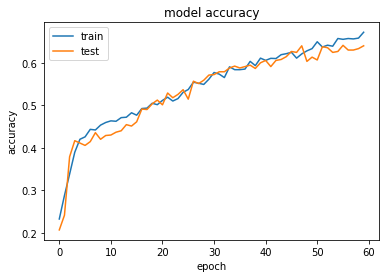

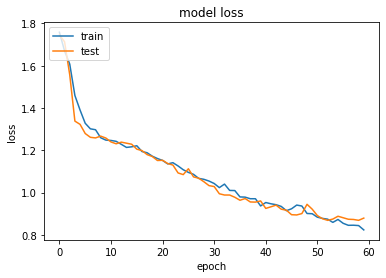

In [987]:
plt.plot(cnnhistory_lstm_mel.history['categorical_accuracy'])
plt.plot(cnnhistory_lstm_mel.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnnhistory_lstm_mel.history['loss'])
plt.plot(cnnhistory_lstm_mel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[103  10   7   1   4   5]
 [ 58  41  23   0  11  20]
 [ 28  20  51   1  14  30]
 [  0   0   0 158   0   0]
 [  0   0   0   0 165   0]
 [ 30  10  40   0  12  58]]


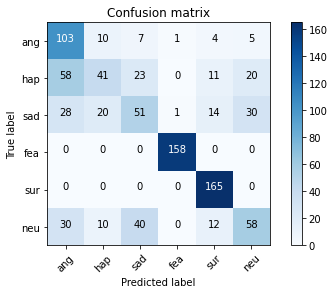

In [1078]:
y_pred = model_mel_lstm.predict(X_testcnn_mel)
matrix = metrics.confusion_matrix(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [1079]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.47      0.79      0.59       130
         hap       0.51      0.27      0.35       153
         sad       0.42      0.35      0.38       144
         fea       0.99      1.00      0.99       158
         sur       0.80      1.00      0.89       165
         neu       0.51      0.39      0.44       150

    accuracy                           0.64       900
   macro avg       0.62      0.63      0.61       900
weighted avg       0.63      0.64      0.62       900



In [1080]:
# indices and labels of all correctly recognized
correct_indices = print_index(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1))
correct_labels = print_labels(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1))

# indices of correctly recognized AND clipped
indices_of_clipped_recognized = []
for i in range(len(X_testcnn_mel)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i in x_clipped):
                indices_of_clipped_recognized.append(i)

label_of_clipped_recognized = []
# we get the label of correctly recognized clipped audios
for i in range(len(y_onehot_test_mel.argmax(axis=1))):
    if(i in indices_of_clipped_recognized):
        label_of_clipped_recognized.append((y_onehot_test_mel.argmax(axis=1)[i]))

dic_val_clipped = count_label(label_of_clipped_recognized)

In [1081]:
dic_val_clipped

{'ang': 8, 'hap': 2, 'sad': 4, 'fea': 0, 'sur': 7, 'neu': 3}

<BarContainer object of 6 artists>

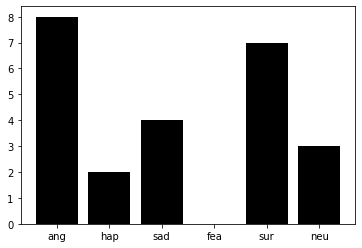

In [1082]:
plt.bar(list(dic_val_clipped.keys()), dic_val_clipped.values(), color='black')

In [1083]:
clipped_ratio = len(indices_of_clipped_recognized) / len(x_clipped)
print("Number of recognized clipped test data: {}\nTotal number of clipped test data: {}\nRatio of recognized clipped test data: {}\n".format(len(indices_of_clipped_recognized),len(x_clipped), clipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_clipped['ang'],dic_val_clipped['hap'],dic_val_clipped['sad'],dic_val_clipped['sur'],dic_val_clipped['neu'],dic_val_clipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val['ang'],dic_true_val['hap'],dic_true_val['sad'],dic_true_val['sur'],dic_true_val['neu'],dic_true_val['fea']))

Number of recognized clipped test data: 24
Total number of clipped test data: 40
Ratio of recognized clipped test data: 0.6

Anger: 8
Happiness: 2
Sadness: 4
Surpise: 7
Neutral: 3
Fear: 0

Anger: 8
Happiness: 9
Sadness: 10
Surpise: 7
Neutral: 6
Fear: 0



In [1084]:
# we get the indices of correctly recognized un-clipped audios
indices_of_unclipped_recognized = []
for i in range(len(X_testcnn_mel)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i not in x_clipped):
                indices_of_unclipped_recognized.append(i)

label_of_unclipped_recognized = []
# we get the label of correctly recognized unclipped audios
for i in range(len(y_onehot_test_mel.argmax(axis=1))):
    if(i in indices_of_unclipped_recognized):
        label_of_unclipped_recognized.append((y_onehot_test_mel.argmax(axis=1)[i]))

dic_val_unclipped = count_label(label_of_unclipped_recognized)

In [1085]:
dic_val_unclipped

{'ang': 95, 'hap': 39, 'sad': 47, 'fea': 158, 'sur': 158, 'neu': 55}

<BarContainer object of 6 artists>

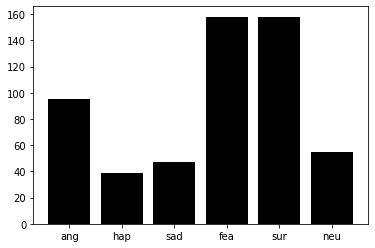

In [1086]:
plt.bar(list(dic_val_unclipped.keys()), dic_val_unclipped.values(), color='black')

In [1087]:
unclipped_ratio = len(indices_of_unclipped_recognized) / len(x_unclipped)
print("Number of recognized unclipped test data: {}\nTotal number of unclipped test data: {}\nRatio of recognized unclipped test data: {}\n".format(len(indices_of_unclipped_recognized),len(x_unclipped), unclipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_unclipped['ang'],dic_val_unclipped['hap'],dic_val_unclipped['sad'],dic_val_unclipped['sur'],dic_val_unclipped['neu'],dic_val_unclipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val_unclipped['ang'],dic_true_val_unclipped['hap'],dic_true_val_unclipped['sad'],dic_true_val_unclipped['sur'],dic_true_val_unclipped['neu'],dic_true_val_unclipped['fea']))

Number of recognized unclipped test data: 552
Total number of unclipped test data: 860
Ratio of recognized unclipped test data: 0.641860465116279

Anger: 95
Happiness: 39
Sadness: 47
Surpise: 158
Neutral: 55
Fear: 158

Anger: 122
Happiness: 144
Sadness: 134
Surpise: 158
Neutral: 144
Fear: 158



## BASE CNN

#### MFCC

In [478]:
model_mfcc_base = Sequential()

model_mfcc_base.add(Conv1D(32, 6,padding='same',input_shape=(40,1)))        #1
model_mfcc_base.add(Activation('relu'))
model_mfcc_base.add(MaxPooling1D(pool_size=(5)))
model_mfcc_base.add(Dropout(0.01))

model_mfcc_base.add(Conv1D(128, 6,padding='same',))                           #2
model_mfcc_base.add(Activation('relu'))
#model_mfcc_base.add(MaxPooling1D(pool_size=(5)))
model_mfcc_base.add(Dropout(0.01))

model_mfcc_base.add(GlobalMaxPooling1D())
model_mfcc_base.add(Dense(6))                                                 #5
model_mfcc_base.add(Activation('softmax'))

In [479]:
model_mfcc_base.summary()

Model: "sequential_73"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_127 (Conv1D)          (None, 40, 32)            224       
_________________________________________________________________
activation_164 (Activation)  (None, 40, 32)            0         
_________________________________________________________________
max_pooling1d_93 (MaxPooling (None, 8, 32)             0         
_________________________________________________________________
dropout_171 (Dropout)        (None, 8, 32)             0         
_________________________________________________________________
conv1d_128 (Conv1D)          (None, 8, 128)            24704     
_________________________________________________________________
activation_165 (Activation)  (None, 8, 128)            0         
_________________________________________________________________
dropout_172 (Dropout)        (None, 8, 128)          

In [480]:
model_mfcc_base.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['categorical_accuracy', f1_loss])

In [481]:
cnnhistory_base_mfcc=model_mfcc_base.fit(X_traincnn_mfcc, y_onehot_train_mfcc, batch_size=50, epochs=100, validation_data=(X_testcnn_mfcc, y_onehot_test_mfcc), callbacks=[mcp_save, rlrop])

Epoch 1/100
42/42 [==============================] - 2s 21ms/step - loss: 16.1315 - categorical_accuracy: 0.1943 - f1_loss: 0.9100 - val_loss: 3.3241 - val_categorical_accuracy: 0.3167 - val_f1_loss: 0.7720
Epoch 2/100
42/42 [==============================] - 0s 12ms/step - loss: 2.6137 - categorical_accuracy: 0.3192 - f1_loss: 0.7455 - val_loss: 1.5833 - val_categorical_accuracy: 0.3500 - val_f1_loss: 0.7205
Epoch 3/100
42/42 [==============================] - 0s 11ms/step - loss: 1.9486 - categorical_accuracy: 0.3546 - f1_loss: 0.6984 - val_loss: 1.7679 - val_categorical_accuracy: 0.4267 - val_f1_loss: 0.6994
Epoch 4/100
42/42 [==============================] - 1s 13ms/step - loss: 1.8309 - categorical_accuracy: 0.3812 - f1_loss: 0.6996 - val_loss: 1.7848 - val_categorical_accuracy: 0.3456 - val_f1_loss: 0.7139
Epoch 5/100
42/42 [==============================] - 0s 11ms/step - loss: 1.9485 - categorical_accuracy: 0.3633 - f1_loss: 0.7049 - val_loss: 1.4644 - val_categorical_accuracy

In [1005]:
loss, acc, f1_score = model_mfcc_base.evaluate(X_testcnn_mfcc, y_onehot_test_mfcc)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 3ms/step - loss: 0.7913 - categorical_accuracy: 0.6933 - f1_loss: 0.4358
Restored model, accuracy: 69.33%


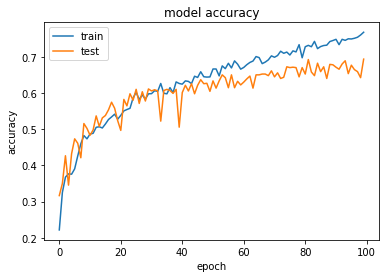

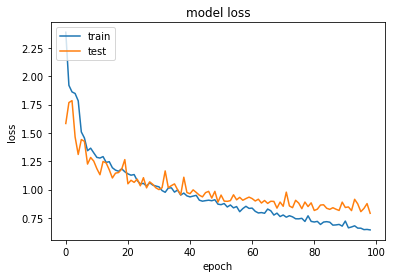

In [1006]:
plt.plot(cnnhistory_base_mfcc.history['categorical_accuracy'])
plt.plot(cnnhistory_base_mfcc.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnnhistory_base_mfcc.history['loss'][1:])
plt.plot(cnnhistory_base_mfcc.history['val_loss'][1:])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[ 91  13   8   0   7  11]
 [ 23  79  14   0  20  17]
 [ 20  17  68   1   3  35]
 [  0   0   0 158   0   0]
 [  0   4   0   5 152   4]
 [  9  24  32   1   8  76]]


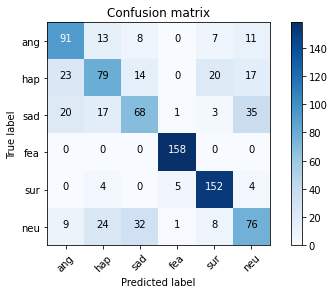

In [1088]:
y_pred = model_mfcc_base.predict(X_testcnn_mfcc)
matrix = metrics.confusion_matrix(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [1089]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.64      0.70      0.67       130
         hap       0.58      0.52      0.54       153
         sad       0.56      0.47      0.51       144
         fea       0.96      1.00      0.98       158
         sur       0.80      0.92      0.86       165
         neu       0.53      0.51      0.52       150

    accuracy                           0.69       900
   macro avg       0.68      0.69      0.68       900
weighted avg       0.68      0.69      0.69       900



In [1090]:
# indices and labels of all correctly recognized
correct_indices = print_index(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
correct_labels = print_labels(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))

# indices of correctly recognized AND clipped
indices_of_clipped_recognized = []
for i in range(len(X_testcnn_mel)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i in x_clipped):
                indices_of_clipped_recognized.append(i)

label_of_clipped_recognized = []
# we get the label of correctly recognized clipped audios
for i in range(len(y_onehot_test_mel.argmax(axis=1))):
    if(i in indices_of_clipped_recognized):
        label_of_clipped_recognized.append((y_onehot_test_mel.argmax(axis=1)[i]))

dic_val_clipped = count_label(label_of_clipped_recognized)

In [1091]:
dic_val_clipped

{'ang': 8, 'hap': 6, 'sad': 5, 'fea': 0, 'sur': 7, 'neu': 5}

<BarContainer object of 6 artists>

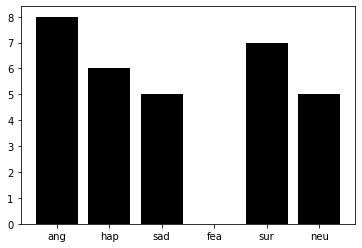

In [1092]:
plt.bar(list(dic_val_clipped.keys()), dic_val_clipped.values(), color='black')

In [1093]:
clipped_ratio = len(indices_of_clipped_recognized) / len(x_clipped)
print("Number of recognized clipped test data: {}\nTotal number of clipped test data: {}\nRatio of recognized clipped test data: {}\n".format(len(indices_of_clipped_recognized),len(x_clipped), clipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_clipped['ang'],dic_val_clipped['hap'],dic_val_clipped['sad'],dic_val_clipped['sur'],dic_val_clipped['neu'],dic_val_clipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val['ang'],dic_true_val['hap'],dic_true_val['sad'],dic_true_val['sur'],dic_true_val['neu'],dic_true_val['fea']))

Number of recognized clipped test data: 31
Total number of clipped test data: 40
Ratio of recognized clipped test data: 0.775

Anger: 8
Happiness: 6
Sadness: 5
Surpise: 7
Neutral: 5
Fear: 0

Anger: 8
Happiness: 9
Sadness: 10
Surpise: 7
Neutral: 6
Fear: 0



In [1094]:
# we get the indices of correctly recognized un-clipped audios
indices_of_unclipped_recognized = []
for i in range(len(X_testcnn_mel)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i not in x_clipped):
                indices_of_unclipped_recognized.append(i)

label_of_unclipped_recognized = []
# we get the label of correctly recognized unclipped audios
for i in range(len(y_onehot_test_mel.argmax(axis=1))):
    if(i in indices_of_unclipped_recognized):
        label_of_unclipped_recognized.append((y_onehot_test_mel.argmax(axis=1)[i]))

dic_val_unclipped = count_label(label_of_unclipped_recognized)

In [1095]:
dic_val_unclipped

{'ang': 83, 'hap': 73, 'sad': 63, 'fea': 158, 'sur': 145, 'neu': 71}

<BarContainer object of 6 artists>

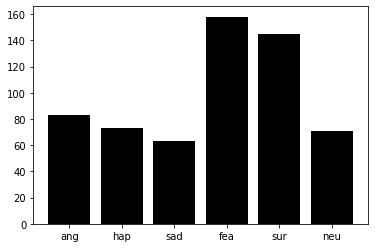

In [1096]:
plt.bar(list(dic_val_unclipped.keys()), dic_val_unclipped.values(), color='black')

In [1097]:
unclipped_ratio = len(indices_of_unclipped_recognized) / len(x_unclipped)
print("Number of recognized unclipped test data: {}\nTotal number of unclipped test data: {}\nRatio of recognized unclipped test data: {}\n".format(len(indices_of_unclipped_recognized),len(x_unclipped), unclipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_unclipped['ang'],dic_val_unclipped['hap'],dic_val_unclipped['sad'],dic_val_unclipped['sur'],dic_val_unclipped['neu'],dic_val_unclipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val_unclipped['ang'],dic_true_val_unclipped['hap'],dic_true_val_unclipped['sad'],dic_true_val_unclipped['sur'],dic_true_val_unclipped['neu'],dic_true_val_unclipped['fea']))

Number of recognized unclipped test data: 593
Total number of unclipped test data: 860
Ratio of recognized unclipped test data: 0.6895348837209302

Anger: 83
Happiness: 73
Sadness: 63
Surpise: 145
Neutral: 71
Fear: 158

Anger: 122
Happiness: 144
Sadness: 134
Surpise: 158
Neutral: 144
Fear: 158



#### Mel

In [782]:
model_mel_base = Sequential()

model_mel_base.add(Conv1D(32, 6,padding='same',input_shape=(128,1)))        #1
model_mel_base.add(Activation('relu'))
#model_mel_base.add(MaxPooling1D(pool_size=(5)))
model_mel_base.add(BatchNormalization())
model_mel_base.add(Dropout(0.01))

model_mel_base.add(Conv1D(64, 6,padding='same',))                           #2
model_mel_base.add(Activation('relu'))
#model_mel_base.add(BatchNormalization())
model_mel_base.add(Dropout(0.01))

model_mel_base.add(GlobalMaxPooling1D())
model_mel_base.add(Dense(6))                                                 #5
model_mel_base.add(Activation('softmax'))

In [783]:
model_mel_base.summary()
model_mel_base.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['categorical_accuracy', f1_loss])

Model: "sequential_112"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_181 (Conv1D)          (None, 128, 32)           224       
_________________________________________________________________
activation_223 (Activation)  (None, 128, 32)           0         
_________________________________________________________________
batch_normalization_135 (Bat (None, 128, 32)           128       
_________________________________________________________________
dropout_286 (Dropout)        (None, 128, 32)           0         
_________________________________________________________________
conv1d_182 (Conv1D)          (None, 128, 64)           12352     
_________________________________________________________________
activation_224 (Activation)  (None, 128, 64)           0         
_________________________________________________________________
dropout_287 (Dropout)        (None, 128, 64)        

In [784]:
cnnhistory_base_mel=model_mel_base.fit(X_traincnn_mel, y_onehot_train_mel, batch_size=50, epochs=60, validation_data=(X_testcnn_mel, y_onehot_test_mel), callbacks=[mcp_save, rlrop])

Epoch 1/60
42/42 [==============================] - 2s 22ms/step - loss: 2.6138 - categorical_accuracy: 0.2135 - f1_loss: 0.8275 - val_loss: 2.4897 - val_categorical_accuracy: 0.2400 - val_f1_loss: 0.7767
Epoch 2/60
42/42 [==============================] - 1s 16ms/step - loss: 1.7367 - categorical_accuracy: 0.3401 - f1_loss: 0.7492 - val_loss: 1.8102 - val_categorical_accuracy: 0.3022 - val_f1_loss: 0.7457
Epoch 3/60
42/42 [==============================] - 1s 17ms/step - loss: 1.5747 - categorical_accuracy: 0.3975 - f1_loss: 0.7215 - val_loss: 1.5127 - val_categorical_accuracy: 0.4189 - val_f1_loss: 0.7086
Epoch 4/60
42/42 [==============================] - 1s 17ms/step - loss: 1.5163 - categorical_accuracy: 0.4170 - f1_loss: 0.7065 - val_loss: 1.5173 - val_categorical_accuracy: 0.4100 - val_f1_loss: 0.6999
Epoch 5/60
42/42 [==============================] - 1s 16ms/step - loss: 1.3974 - categorical_accuracy: 0.4549 - f1_loss: 0.6858 - val_loss: 1.5139 - val_categorical_accuracy: 0.41

In [785]:
loss, acc, f1_score = model_mel_base.evaluate(X_testcnn_mel, y_onehot_test_mel)
print("Restored model, accuracy: {:5.2f}%".format(100*acc))

29/29 [==============================] - 0s 4ms/step - loss: 1.1422 - categorical_accuracy: 0.5722 - f1_loss: 0.5482
Restored model, accuracy: 57.22%


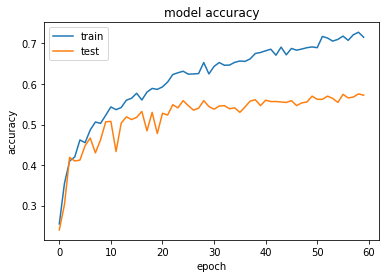

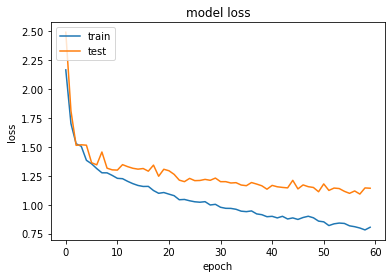

In [786]:
plt.plot(cnnhistory_base_mel.history['categorical_accuracy'])
plt.plot(cnnhistory_base_mel.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(cnnhistory_base_mel.history['loss'])
plt.plot(cnnhistory_base_mel.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Confusion matrix, without normalization
[[ 65  28  13   4   3  17]
 [ 29  55   9   4   8  48]
 [ 21  43  21   5   6  48]
 [  0   0   0 158   0   0]
 [  6   1   0   4 154   0]
 [ 12  35  24   5  12  62]]


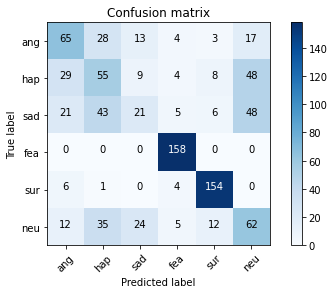

In [1098]:
y_pred = model_mel_base.predict(X_testcnn_mel)
matrix = metrics.confusion_matrix(y_onehot_test_mel.argmax(axis=1), y_pred.argmax(axis=1))
emo_keys = list(['ang', 'hap', 'sad', 'fea', 'sur', 'neu'])
plot_confusion_matrix(matrix, classes=emo_keys)

In [1099]:
target_names = ['ang', 'hap', 'sad', 'fea', 'sur', 'neu']
print(classification_report(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1), target_names=target_names))

              precision    recall  f1-score   support

         ang       0.49      0.50      0.49       130
         hap       0.34      0.36      0.35       153
         sad       0.31      0.15      0.20       144
         fea       0.88      1.00      0.93       158
         sur       0.84      0.93      0.89       165
         neu       0.35      0.41      0.38       150

    accuracy                           0.57       900
   macro avg       0.54      0.56      0.54       900
weighted avg       0.55      0.57      0.55       900



In [1100]:
# indices and labels of all correctly recognized
correct_indices = print_index(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))
correct_labels = print_labels(y_onehot_test_mfcc.argmax(axis=1), y_pred.argmax(axis=1))

# indices of correctly recognized AND clipped
indices_of_clipped_recognized = []
for i in range(len(X_testcnn_mel)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i in x_clipped):
                indices_of_clipped_recognized.append(i)

label_of_clipped_recognized = []
# we get the label of correctly recognized clipped audios
for i in range(len(y_onehot_test_mel.argmax(axis=1))):
    if(i in indices_of_clipped_recognized):
        label_of_clipped_recognized.append((y_onehot_test_mel.argmax(axis=1)[i]))

dic_val_clipped = count_label(label_of_clipped_recognized)

In [1101]:
dic_val_clipped

{'ang': 8, 'hap': 3, 'sad': 1, 'fea': 0, 'sur': 7, 'neu': 2}

<BarContainer object of 6 artists>

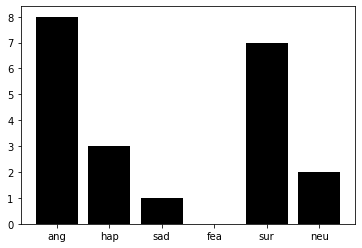

In [1102]:
plt.bar(list(dic_val_clipped.keys()), dic_val_clipped.values(), color='black')

In [1103]:
clipped_ratio = len(indices_of_clipped_recognized) / len(x_clipped)
print("Number of recognized clipped test data: {}\nTotal number of clipped test data: {}\nRatio of recognized clipped test data: {}\n".format(len(indices_of_clipped_recognized),len(x_clipped), clipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_clipped['ang'],dic_val_clipped['hap'],dic_val_clipped['sad'],dic_val_clipped['sur'],dic_val_clipped['neu'],dic_val_clipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val['ang'],dic_true_val['hap'],dic_true_val['sad'],dic_true_val['sur'],dic_true_val['neu'],dic_true_val['fea']))

Number of recognized clipped test data: 21
Total number of clipped test data: 40
Ratio of recognized clipped test data: 0.525

Anger: 8
Happiness: 3
Sadness: 1
Surpise: 7
Neutral: 2
Fear: 0

Anger: 8
Happiness: 9
Sadness: 10
Surpise: 7
Neutral: 6
Fear: 0



In [1104]:
# we get the indices of correctly recognized un-clipped audios
indices_of_unclipped_recognized = []
for i in range(len(X_testcnn_mel)):
    for j in range(len(correct_indices)):
        if(i == correct_indices[j]):
            if(i not in x_clipped):
                indices_of_unclipped_recognized.append(i)

label_of_unclipped_recognized = []
# we get the label of correctly recognized unclipped audios
for i in range(len(y_onehot_test_mel.argmax(axis=1))):
    if(i in indices_of_unclipped_recognized):
        label_of_unclipped_recognized.append((y_onehot_test_mel.argmax(axis=1)[i]))

dic_val_unclipped = count_label(label_of_unclipped_recognized)

In [1105]:
dic_val_unclipped

{'ang': 57, 'hap': 52, 'sad': 20, 'fea': 158, 'sur': 147, 'neu': 60}

<BarContainer object of 6 artists>

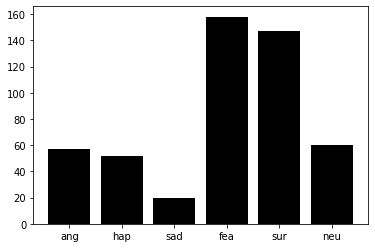

In [1026]:
plt.bar(list(dic_val_unclipped.keys()), dic_val_unclipped.values(), color='black')

In [1106]:
unclipped_ratio = len(indices_of_unclipped_recognized) / len(x_unclipped)
print("Number of recognized unclipped test data: {}\nTotal number of unclipped test data: {}\nRatio of recognized unclipped test data: {}\n".format(len(indices_of_unclipped_recognized),len(x_unclipped), unclipped_ratio ))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_val_unclipped['ang'],dic_val_unclipped['hap'],dic_val_unclipped['sad'],dic_val_unclipped['sur'],dic_val_unclipped['neu'],dic_val_unclipped['fea']))
print("Anger: {}\nHappiness: {}\nSadness: {}\nSurpise: {}\nNeutral: {}\nFear: {}\n".format(dic_true_val_unclipped['ang'],dic_true_val_unclipped['hap'],dic_true_val_unclipped['sad'],dic_true_val_unclipped['sur'],dic_true_val_unclipped['neu'],dic_true_val_unclipped['fea']))

Number of recognized unclipped test data: 494
Total number of unclipped test data: 860
Ratio of recognized unclipped test data: 0.5744186046511628

Anger: 57
Happiness: 52
Sadness: 20
Surpise: 147
Neutral: 60
Fear: 158

Anger: 122
Happiness: 144
Sadness: 134
Surpise: 158
Neutral: 144
Fear: 158

